California Housing Prices from Kaggle.
 
The goal of this homework is to create a regression model for predicting housing prices (column 'median_house_value').

In [2]:
import pandas as pd 
import numpy as np

In [3]:
dataset = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv')

dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Exploring median_house_value variable. Does it have a long tail?

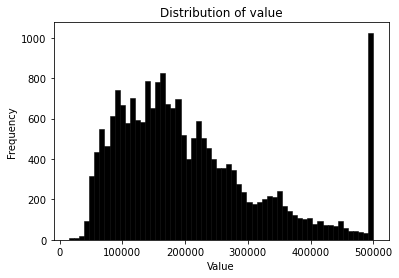

In [7]:
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(6, 4))

sns.histplot(dataset.median_house_value, bins=60, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.title('Distribution of value')

plt.show()

In [8]:
dataset = dataset.drop('ocean_proximity', axis=1)
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


Find a feature with missing values. How many missing values does it have?

In [9]:
dataset.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

What's the median (50% percentile) for variable 'population'?

In [10]:
dataset.population.median()

1166.0

Split the data
Shuffle the initial dataset, use seed 42.
Split your data in train/val/test sets, with 60%/20%/20% distribution.
Make sure that the target value ('median_house_value') is not in your dataframe.
Apply the log transformation to the median_house_value variable using the np.log1p() function.

In [11]:
np.random.seed(2)

n = len(dataset)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

dataset_shuffled = dataset.iloc[idx]

dataset_train = dataset_shuffled.iloc[:n_train].copy()
dataset_val = dataset_shuffled.iloc[n_train:n_train+n_val].copy()
dataset_test = dataset_shuffled.iloc[n_train+n_val:].copy()

y_train_orig = dataset_train.median_house_value.values
y_val_orig = dataset_val.median_house_value.values
y_test_orig = dataset_test.median_house_value.values

y_train = np.log1p(dataset_train.median_house_value.values)
y_val = np.log1p(dataset_val.median_house_value.values)
y_test = np.log1p(dataset_test.median_house_value.values)

del dataset_train['median_house_value']
del dataset_val['median_house_value']
del dataset_test['median_house_value']

We need to deal with missing values for the total_bedrooms.
We have two options: fill it with 0 or with the mean of this variable.

Try both options. For each, train a linear regression model without regularization using the code from the lessons.
For computing the mean, use the training only!

Use the validation dataset to evaluate the models and compare the RMSE of each option.
Round the RMSE scores to 2 decimal digits using round(score, 2)
Which option gives better RMSE?

In [12]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

def prepare_X_0(df):
    df = df.fillna(0)
    X = df.values
    return X

def prepare_X_mean(df):
    df = df.fillna(df.total_bedrooms.mean())
    X = df.values
    return X

def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [24]:
X_train_0 = prepare_X_0(dataset_train)
w_0_0, w_0 = train_linear_regression(X_train_0, y_train)
y_pred_0 = w_0_0 + dataset_val.fillna(0).values.dot(w_0)

print(round(rmse(y_val, y_pred_0),2))

0.33


In [25]:
X_train_mean = prepare_X_mean(dataset_train)
w_0_mean, w_mean = train_linear_regression(X_train_mean, y_train)
y_pred_mean = w_0_mean + dataset_val.fillna(dataset_val.total_bedrooms.mean()).values.dot(w_mean)

print(round(rmse(y_val, y_pred_mean),2))

0.33


Now let's train a regularized linear regression.
For this question, fill the NAs with 0.
Try different values of r from this list: [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10].
Use RMSE to evaluate the model on the validation dataset.
Round the RMSE scores to 2 decimal digits.
Which r gives the best RMSE?
If there are multiple options, select the smallest r.

In [21]:
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [28]:
X_train_0 = prepare_X_0(dataset_train)

for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0_0, w_0 = train_linear_regression_reg(X_train_0, y_train,r)
    y_pred_0 = w_0_0 + dataset_val.fillna(0).dot(w_0)

    print(round(rmse(y_val, y_pred_0),2))

0.33
0.33
0.33
0.33
0.33
0.33
0.34
0.34
0.34


Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
For each seed, do the train/validation/test split with 60%/20%/20% distribution.

Fill the missing values with 0 and train a model without regularization.

For each seed, evaluate the model on the validation dataset and collect the RMSE scores.

What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
Round the result to 3 decimal digits (round(std, 3))
Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.

In [29]:
seed = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

res = []

n = len(dataset)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

for s in seed:
    np.random.seed(s)
    idx = np.arange(n)
    np.random.shuffle(idx)

    dataset_shuffled = dataset.iloc[idx]

    dataset_train = dataset_shuffled.iloc[:n_train].copy()
    dataset_val = dataset_shuffled.iloc[n_train:n_train+n_val].copy()
    dataset_test = dataset_shuffled.iloc[n_train+n_val:].copy()
    
    dataset_val = dataset_val.fillna(0)
    dataset_test = dataset_test.fillna(0)

    y_train_orig = dataset_train.median_house_value.values
    y_val_orig = dataset_val.median_house_value.values
    y_test_orig = dataset_test.median_house_value.values

    y_train = np.log1p(dataset_train.median_house_value.values)
    y_val = np.log1p(dataset_val.median_house_value.values)
    y_test = np.log1p(dataset_test.median_house_value.values)

    del dataset_train['median_house_value']
    del dataset_val['median_house_value']
    del dataset_test['median_house_value']
    
    X_train_0 = prepare_X_0(dataset_train)
    w_0_0, w_0 = train_linear_regression(X_train_0, y_train)
    y_pred_0 = w_0_0 + dataset_val.values.dot(w_0)

    res.append(rmse(y_val, y_pred_mean))
    
print(res)

[0.7226806497821303, 0.7259187266197862, 0.33162488763249753, 0.7158300162075574, 0.7254750685551915, 0.7223702292939693, 0.7194436201332992, 0.7081985143811889, 0.714238526643655, 0.7185664402610947]


In [32]:
std = np.std(res)
print(round(std, 3))

0.116


Split the dataset like previously, use seed 9.
Combine train and validation datasets.
Fill the missing values with 0 and train a model with r=0.001.
What's the RMSE on the test dataset?

In [35]:
np.random.seed(9)

n = len(dataset)

n_test = int(0.2 * n)
n_train = n - (n_test)

idx = np.arange(n)
np.random.shuffle(idx)

dataset_shuffled = dataset.iloc[idx]

dataset_train = dataset_shuffled.iloc[:n_train].copy()
dataset_test = dataset_shuffled.iloc[n_train:].copy()
    
y_train_orig = dataset_train.median_house_value.values
  
y_test_orig = dataset_test.median_house_value.values

y_train = np.log1p(dataset_train.median_house_value.values)

y_test = np.log1p(dataset_test.median_house_value.values)

del dataset_train['median_house_value']
del dataset_test['median_house_value']
    
X_train_0 = prepare_X_0(dataset_train)
w_0_0, w_0 = train_linear_regression_reg(X_train_0, y_train, r=0.001)
y_pred_0 = w_0_0 + dataset_test.fillna(0).values.dot(w_0)

print(rmse(y_test, y_pred_0))

0.345316891435843
